In [3]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow.keras import losses
import tensorflow.keras as tfk
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Dense,Conv2D,Conv1D,AveragePooling2D,MaxPool2D,BatchNormalization,Dropout,Flatten

In [ ]:
df = pd.DataFrame(columns=['image','ages','region'])#creating dataframe
x= 0
for i in os.listdir('UTKFace'):
    try:
        split = i.split('_')#parsing label
        con = int(split[2])
        ages = int(split[0])
        image = Image.open('UTKFace\\' + i)
        image = image.resize((110,110))
        image = np.array(image).astype(np.float32)/255.0
        df.loc[x] = [image,ages,con]# storing data
        x += 1
    except:
        continue


(26, 2)

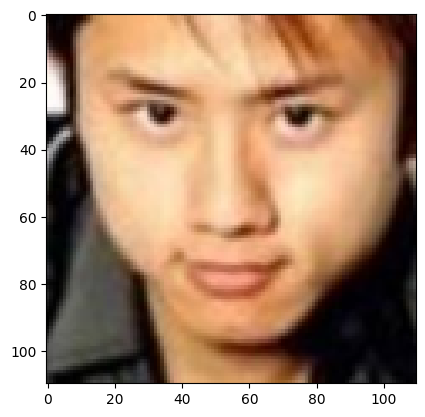

In [5]:
plt.imshow(df['image'][0])
df['ages'][0],df['region'][0]

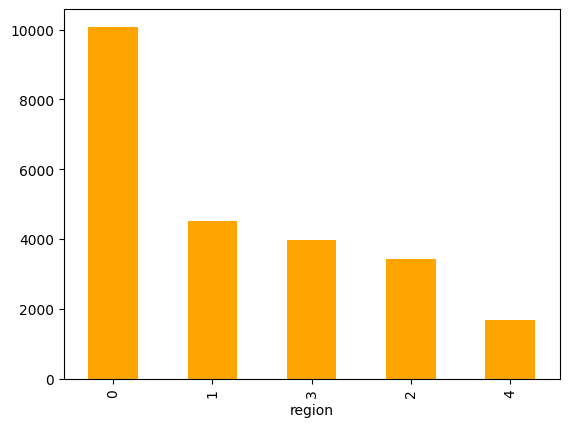

In [ ]:
df['region'].value_counts().plot(kind='bar',color='orange')#counting values in each class 
plt.show()

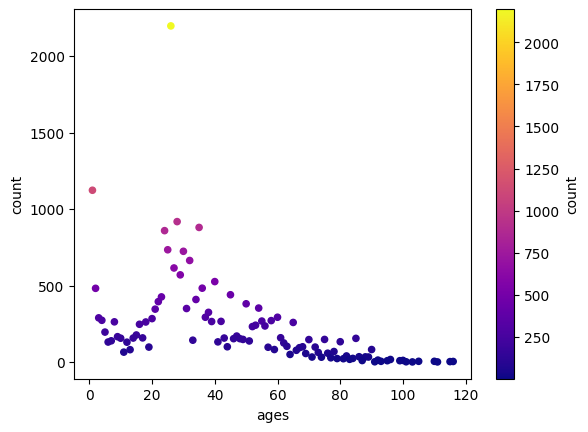

In [ ]:
df['ages'].value_counts().reset_index().plot(kind='scatter',x='ages',y='count',c='count',colormap='plasma')#scatter plot for age
plt.show()


In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)#shuffling data
age_range = [i for i in range(20,40)]
e = 0
filters = df[(df['ages'].isin(age_range))&(df['region']==e)]#seperating data for equal distribution
kf = df[~((df['ages'].isin(age_range))&(df['region']==e))]
df.shape

(23705, 3)

In [9]:
kf.shape,filters.shape

((19970, 3), (3735, 3))

In [ ]:
filters = filters.sample(frac=0.3,random_state=42).reset_index(drop=True)#reducing data for equal distribution
df1 = pd.concat([kf,filters],axis=0)#concating original data with sample data
filters1 = df1[(df1['region']==0)]
kf1 = df1[~(df1['region']==0)]
kf1.shape,filters1.shape

((13627, 3), (7463, 3))

In [ ]:
filters1 = filters1.sample(frac=0.5,random_state=42).reset_index(drop=True)#reducing data
df2 = pd.concat([kf1,filters1],axis=0)
df2.shape

(17359, 3)

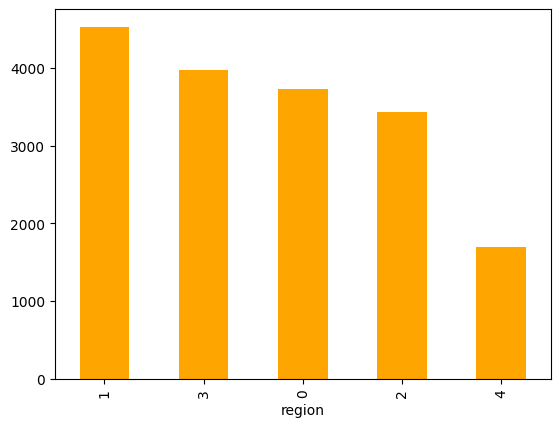

In [12]:
df2['region'].value_counts().plot(kind='bar',color='orange')
plt.show()

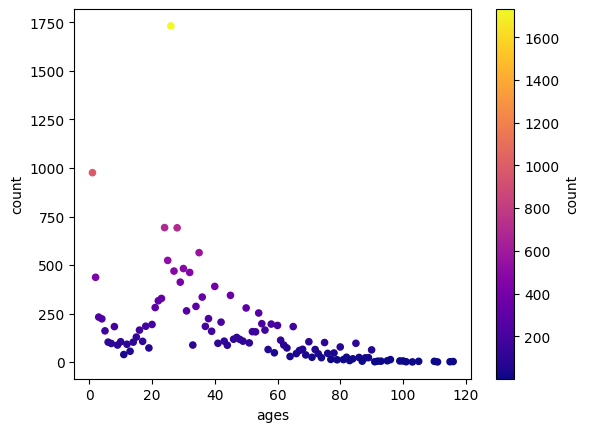

In [13]:
df2['ages'].value_counts().reset_index().plot(kind='scatter',x='ages',y='count',c='count',colormap='plasma')
plt.show()

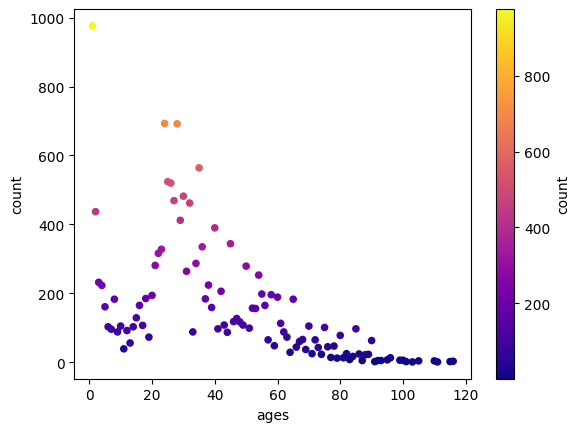

(16147, 3)


In [14]:
age = df2[df2['ages']==26]
age = age.sample(frac=0.3,random_state=42)
age.shape
nage = df2[~(df2['ages']==26)]
org = pd.concat([nage,age],axis=0)
org['ages'].value_counts().reset_index().plot(kind='scatter',x='ages',y='count',c='count',colormap='plasma')
plt.show()
print(org.shape)

In [ ]:
h = np.concatenate(org['image'].__array__())# extracting images from dataframe
h = h.reshape(-1,110,110,3)

In [16]:
x = h
y = np.array([org['region'].values,org['ages'].values])
y = y.T
print(y)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=60,test_size=0.3)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

[[ 2 28]
 [ 1 31]
 [ 2  1]
 ...
 [ 2 26]
 [ 0 26]
 [ 1 26]]


((11302, 110, 110, 3), (4845, 110, 110, 3), (11302, 2), (4845, 2))

In [17]:
y_train = [y_train[:,0],y_train[:,1]]
y_test = [y_test[:,0],y_test[:,1]]
y_train

[array([4, 3, 4, ..., 2, 1, 4]), array([ 2, 24, 29, ...,  2, 37, 20])]

In [18]:
def build(input_shape):
    input = tfk.Input(input_shape)
    con = Conv2D(32,(3,3),activation='relu')(input)
    pool = MaxPool2D((2,2),padding='same')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.2)(batch)
    
    con = Conv2D(64,(3,3),activation='relu')(drop)
    pool = MaxPool2D((2,2),padding='valid')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.3)(batch)
    
    con = Conv2D(128,(3,3),activation='relu')(drop)
    pool = MaxPool2D((3,3),padding='same')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.3)(batch)

    con = Conv2D(256,(3,3),activation='relu')(drop)
    pool = MaxPool2D((2,2),padding='same')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.2)(batch)
    
    con = Conv2D(512,(3,3),activation='relu')(drop)
    pool = MaxPool2D((2,2),padding='same')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.2)(batch)
    
    flat = Flatten()(drop)
    dense = Dense(1000,activation = 'relu')(flat)
    dense = BatchNormalization()(dense)
    
    dense = Dense(600,activation='relu')(dense)
    dense = BatchNormalization()(dense)
    
    dense = Dense(100,activation='relu')(dense)
    dense = BatchNormalization()(dense)
    out = Dense(5,activation='softmax',name='Ethencity')(dense)
    out2 = Dense(1,name='age')(dense)
    
    model = tfk.Model(inputs=input,outputs=[out,out2])
    model.compile(loss=["SparseCategoricalCrossentropy","mae"],optimizer="Adam",metrics=["accuracy",'mae'])
    return model

In [19]:
model =  build((110,110,3))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 110, 110,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 108, 108,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 54, 54,    │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 54, 54,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 52, 52,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 26, 26,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 26, 26,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 6, 256) │    295,168 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 3, 3, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 256) │      1,024 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 3, 3, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 512) │  1,180,160 │ dropout_3[0][0] 

 Total params: 2,753,650 (10.50 MB)

 Trainable params: 2,748,266 (10.48 MB)

 Non-trainable params: 5,384 (21.03 KB)

In [20]:
modelfile='Nationality.keras'
checkp=ModelCheckpoint(modelfile,monitor='val_loss',
                       verbose=1,save_best_only=True,
                       save_weights_only=False,
                       mode='auto',
                       save_freq='epoch')
threshold=EarlyStopping(patience=50,monitor='val_loss',
                                           restore_best_weights='True',
                                           start_from_epoch = 10)

In [21]:
history = model.fit(x_train,y_train,
          batch_size=16,
                validation_data=(x_test,y_test),
                epochs=200,
                shuffle = True,
                steps_per_epoch=len(x_train) // 16,
                callbacks=[checkp,threshold])

model.summary()

Epoch 1/200


I0000 00:00:1729577846.576462     126 service.cc:145] XLA service 0x7a6f70020320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729577846.576521     126 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729577846.576525     126 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 13/706 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - Ethencity_accuracy: 0.2375 - age_mae: 29.8420 - loss: 32.1773 

I0000 00:00:1729577874.575641     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


701/706 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Ethencity_accuracy: 0.3891 - age_mae: 26.1481 - loss: 27.7330
Epoch 1: val_loss improved from inf to 11.99061, saving model to Nationality.keras
706/706 ━━━━━━━━━━━━━━━━━━━━ 45s 16ms/step - Ethencity_accuracy: 0.3894 - age_mae: 26.0875 - loss: 27.6712 - val_Ethencity_accuracy: 0.4533 - val_age_mae: 10.6279 - val_loss: 11.9906
Epoch 2/200
  1/706 ━━━━━━━━━━━━━━━━━━━━ 2:09:31 11s/step - Ethencity_accuracy: 0.1667 - age_mae: 7.0034 - loss: 8.5008

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 11.99061 to 11.86746, saving model to Nationality.keras
706/706 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - Ethencity_accuracy: 0.1667 - age_mae: 7.0034 - loss: 8.5008 - val_Ethencity_accuracy: 0.4625 - val_age_mae: 10.5219 - val_loss: 11.8675
Epoch 3/200
702/706 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Ethencity_accuracy: 0.4867 - age_mae: 10.5013 - loss: 11.8091
Epoch 3: val_loss improved from 11.86746 to 10.04031, saving model to Nationality.keras
706/706 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - Ethencity_accuracy: 0.4868 - age_mae: 10.4973 - loss: 11.8048 - val_Ethencity_accuracy: 0.5154 - val_age_mae: 8.8334 - val_loss: 10.0403
Epoch 4/200
  1/706 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - Ethencity_accuracy: 0.6667 - age_mae: 7.7303 - loss: 9.0153
Epoch 4: val_loss did not improve from 10.04031
706/706 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Ethencity_accuracy: 0.6667 - age_mae: 7.7303 - loss: 9.0153 - val_Ethencity_accuracy: 0.5040 - val_age_mae: 8.9028 - val_loss: 10.1336
Epoc

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 110, 110,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 108, 108,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 54, 54,    │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 54, 54,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 52, 52,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 26, 26,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 26, 26,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 6, 256) │    295,168 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 3, 3, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 256) │      1,024 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 3, 3, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 512) │  1,180,160 │ dropout_3[0][0] 

 Total params: 8,250,184 (31.47 MB)

 Trainable params: 2,748,266 (10.48 MB)

 Non-trainable params: 5,384 (21.03 KB)

 Optimizer params: 5,496,534 (20.97 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1 1


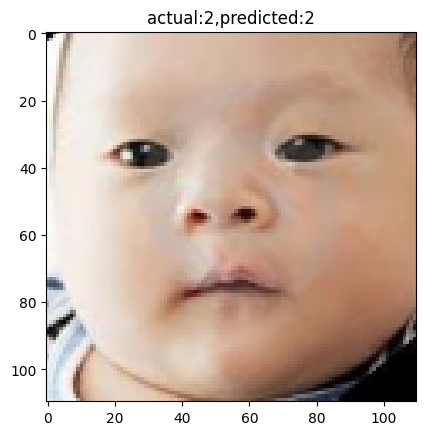

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
25 26


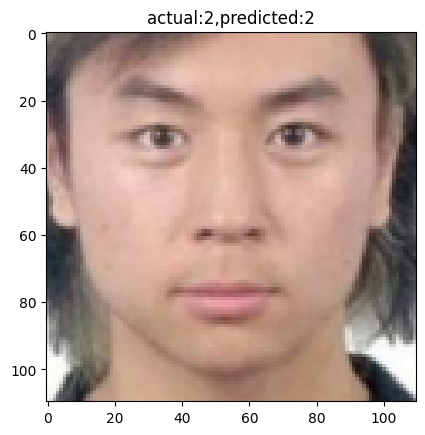

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
31 33


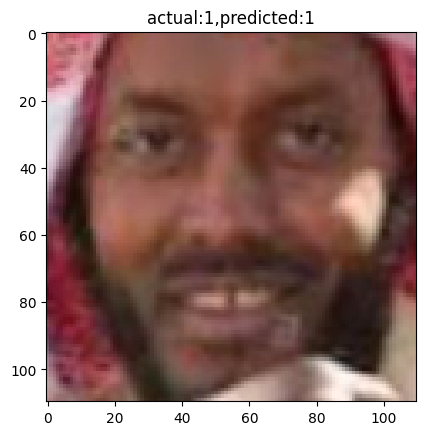

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
30 31


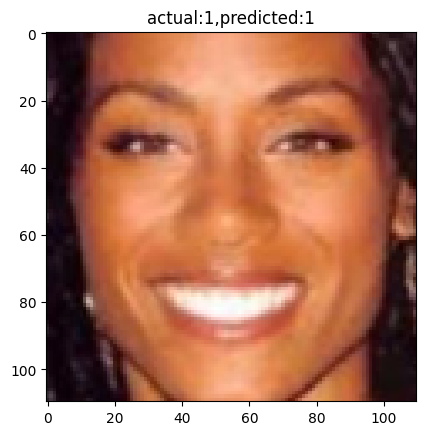

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1 3


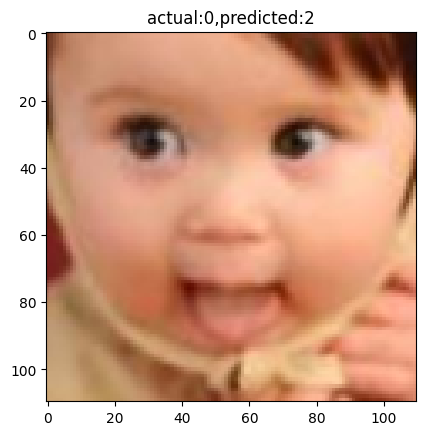

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1 2


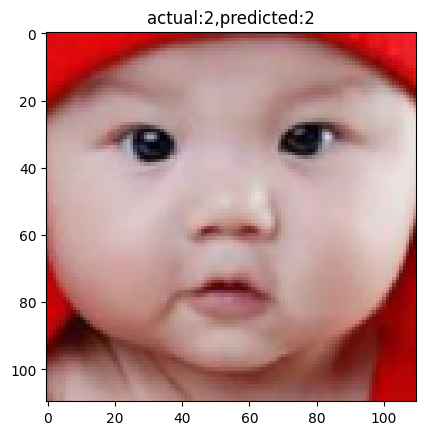

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
27 27


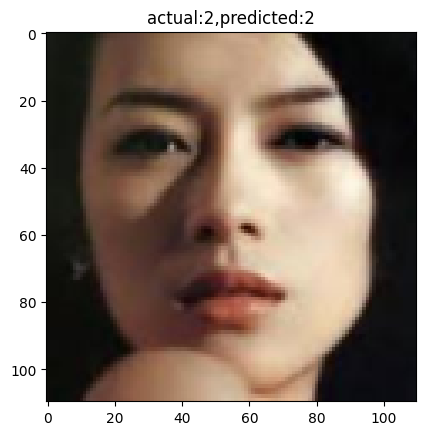

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
57 45


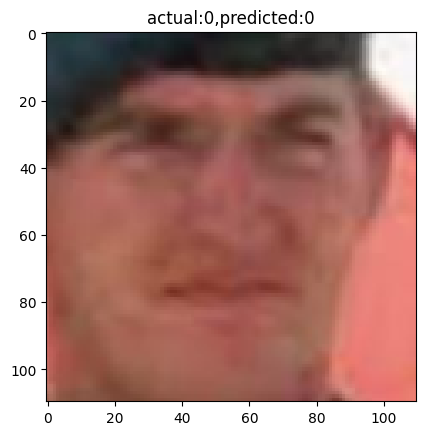

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
48 45


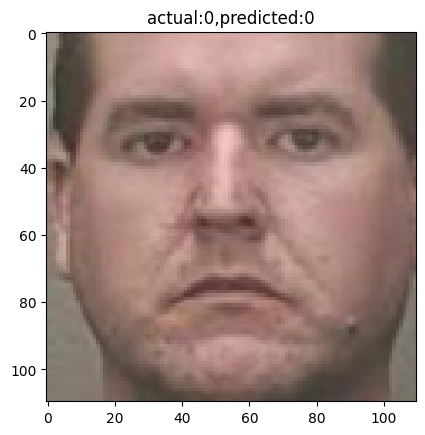

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
29 32


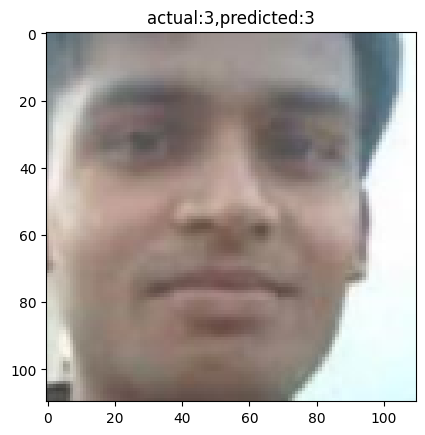

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22 28


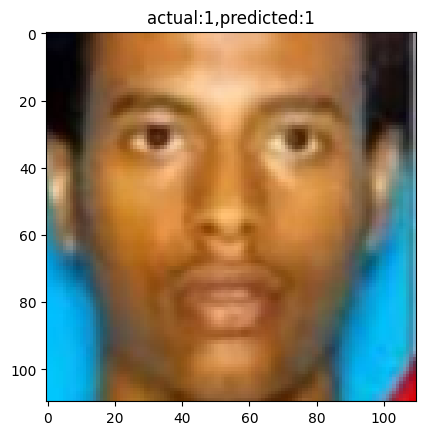

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
26 29


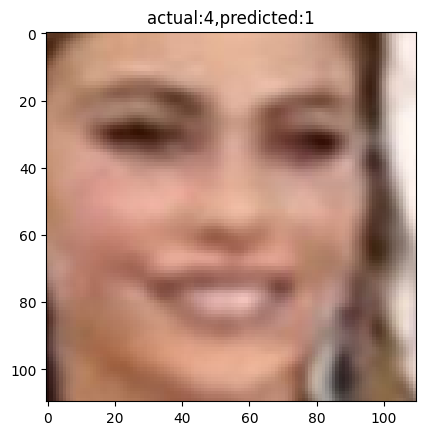

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
25 23


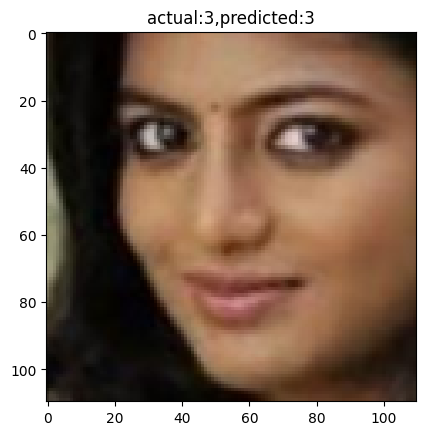

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12 5


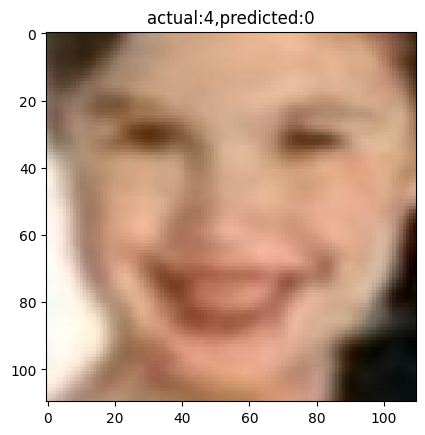

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
25 28


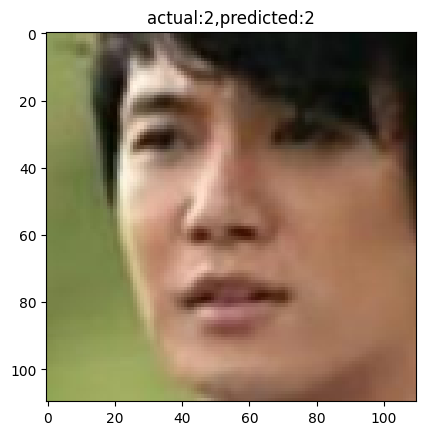

In [22]:
for i in range(15):
    plt.imshow(x_test[i])
    test = np.expand_dims(x_test[i],axis=0)
    predicted =  model.predict(test)
    plt.title(f'actual:{y_test[0][i]},predicted:{np.argmax(predicted[0])}')
    print(y_test[1][i],round(predicted[1][0][0]))
    plt.show()

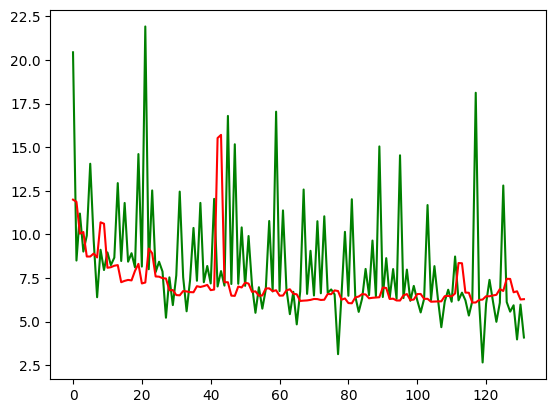

In [27]:
history1 = history.history
loss = history1['loss']
val_loss = history1['val_loss']
plt.plot(loss,c='green')
plt.plot(val_loss,c='red')
plt.show()